In [5]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [100, 100]

apiKey = "apiKey" #change this

## Table Extaction
1.find table
    - find all ractangle
    - find the most area; assume that is table
2.crop table <br>
3.find header 
    - find all ractangle again after crop table
    - find height and weight of ractangle with in the specified range
4.crop each row of header <br>
5.OCR each row <br>
6.repair text <br>

In [6]:
path_img = "lv1.jpg"
image = cv2.imread(path_img)

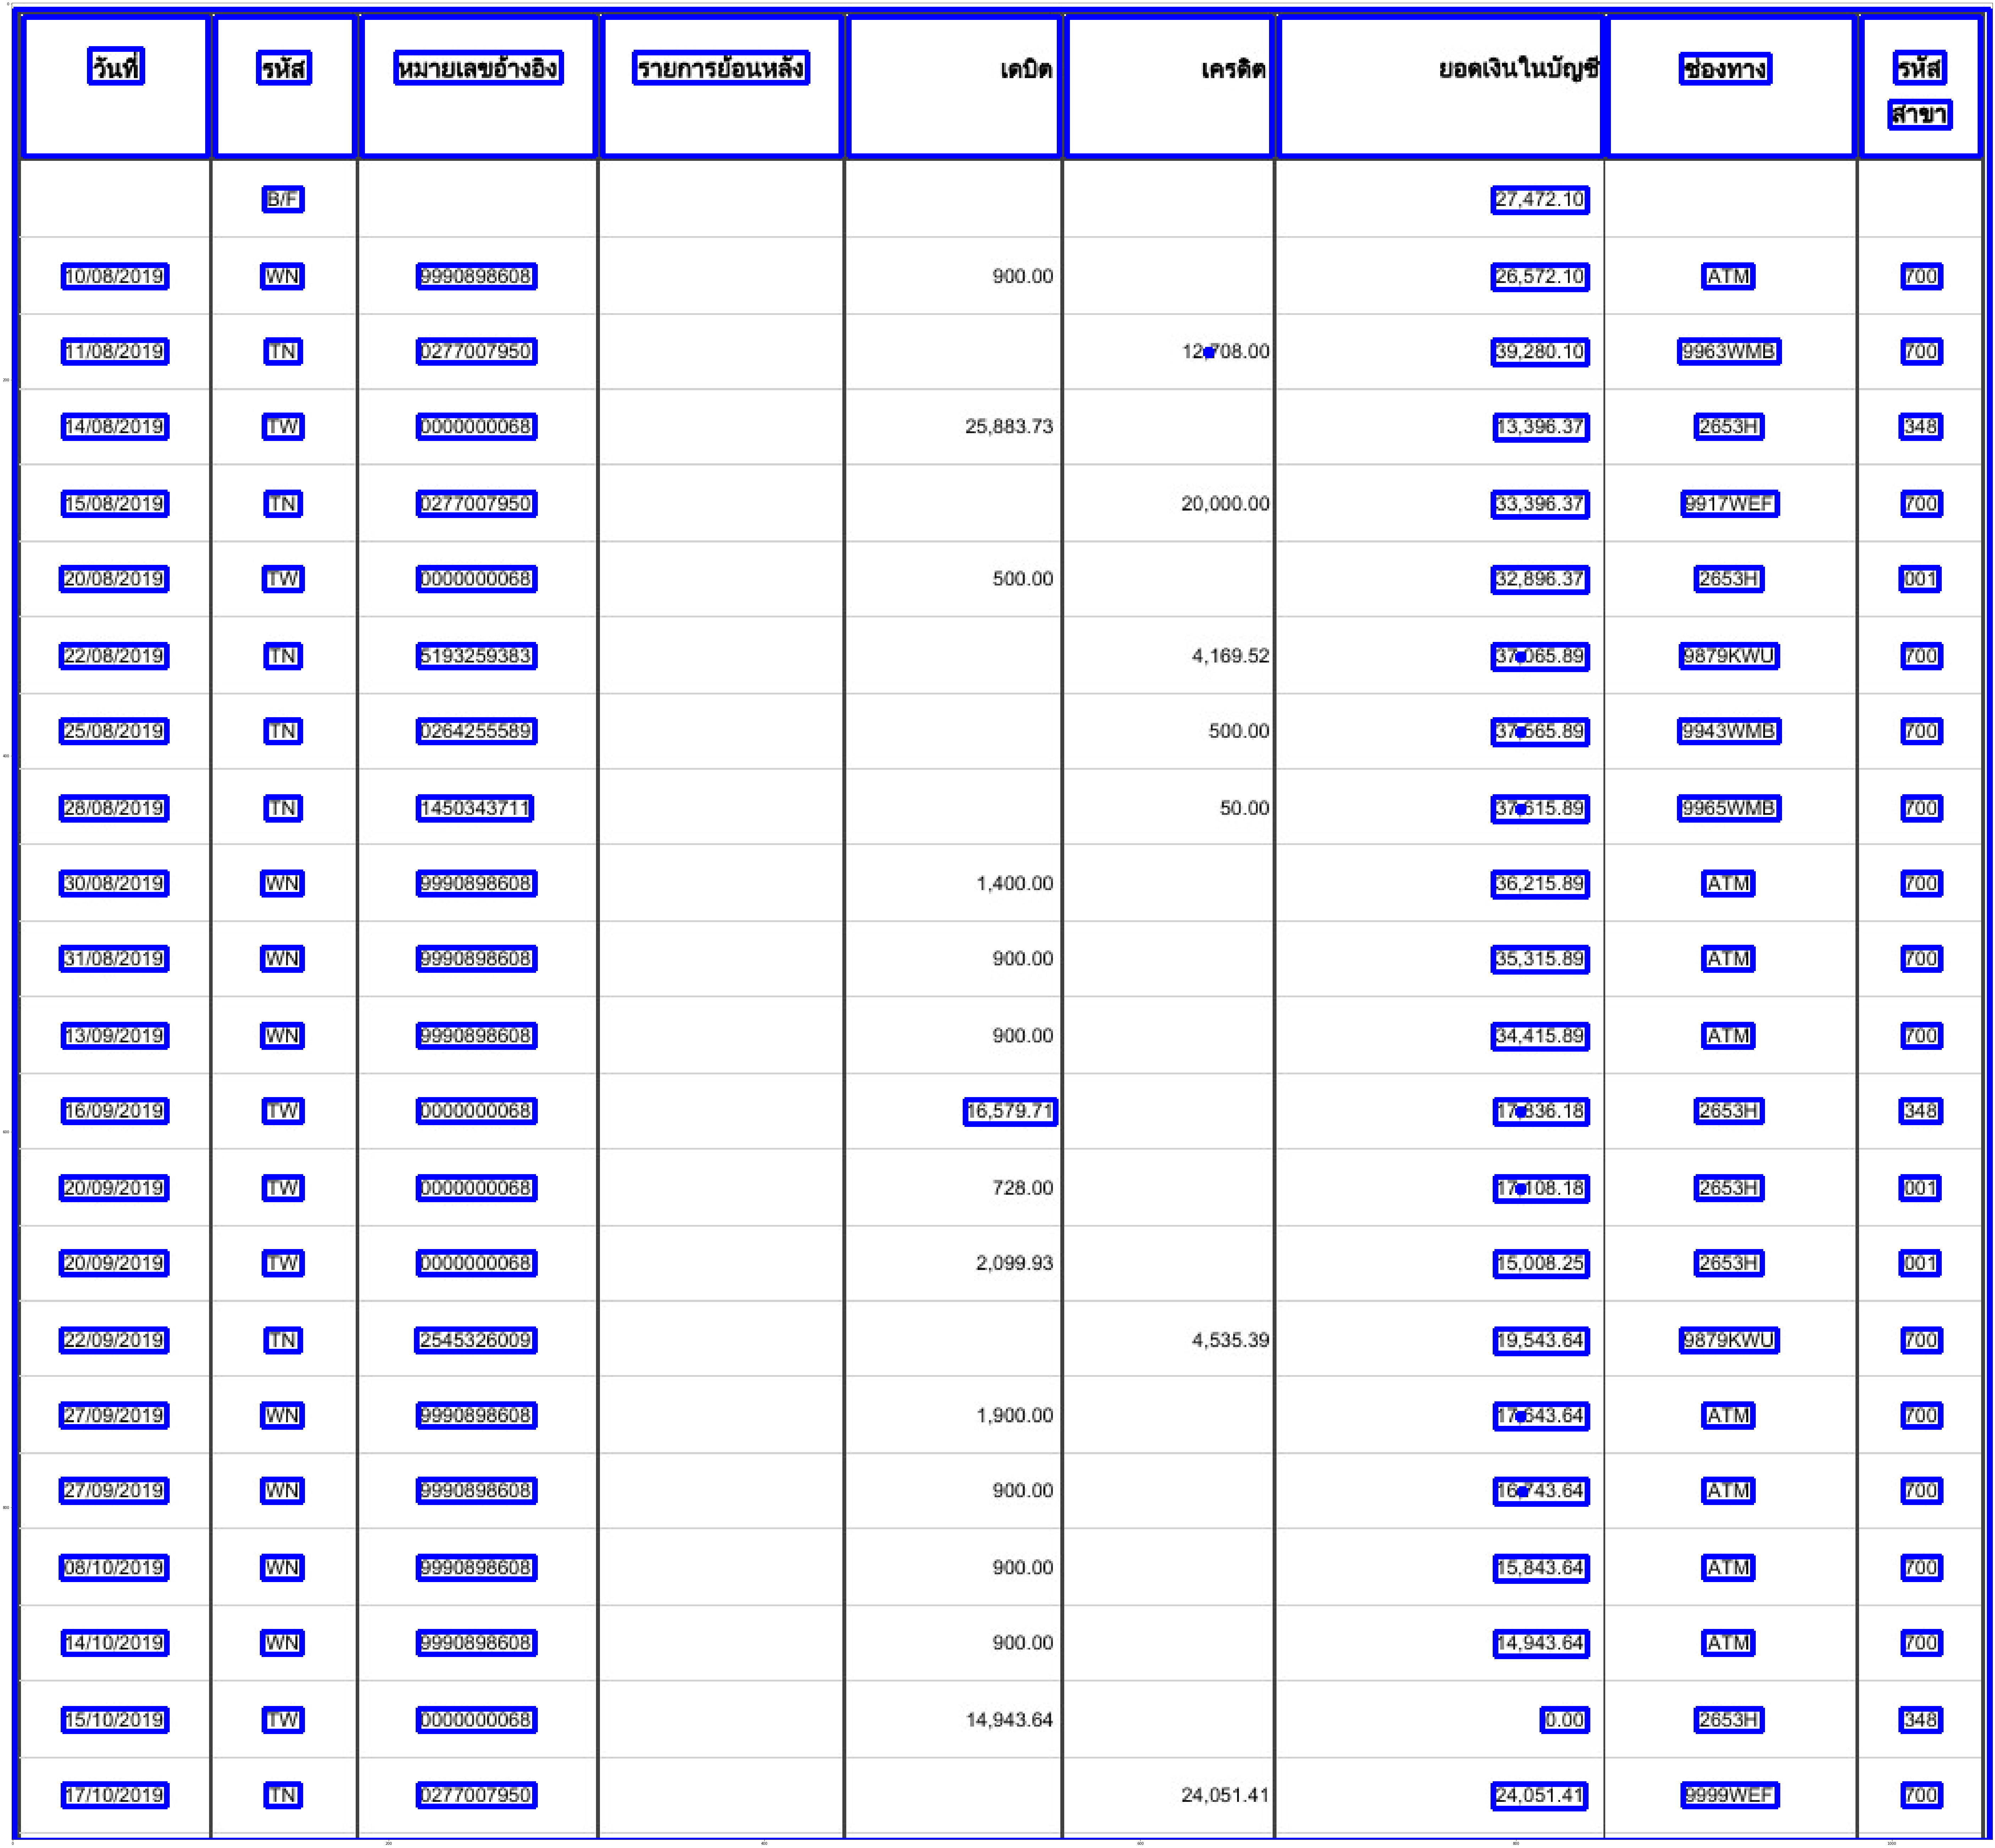

In [7]:
# find All Rectangle

img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh_value = cv2.threshold(img_gray, 180, 255, cv2.THRESH_BINARY_INV)

kernel = np.ones((5,5), np.uint8)
dilated_value = cv2.dilate(thresh_value, kernel, iterations=1)
contours, hierarchy = cv2.findContours(dilated_value, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

rect_pos_list = []
image_draw = image.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    rect_pos_list.append([x, y, w, h])
    cv2.rectangle(image_draw, (x, y), (x+w, y+h), (0, 0, 255), 2)

plt.imshow(image_draw)

1 3 1051 974


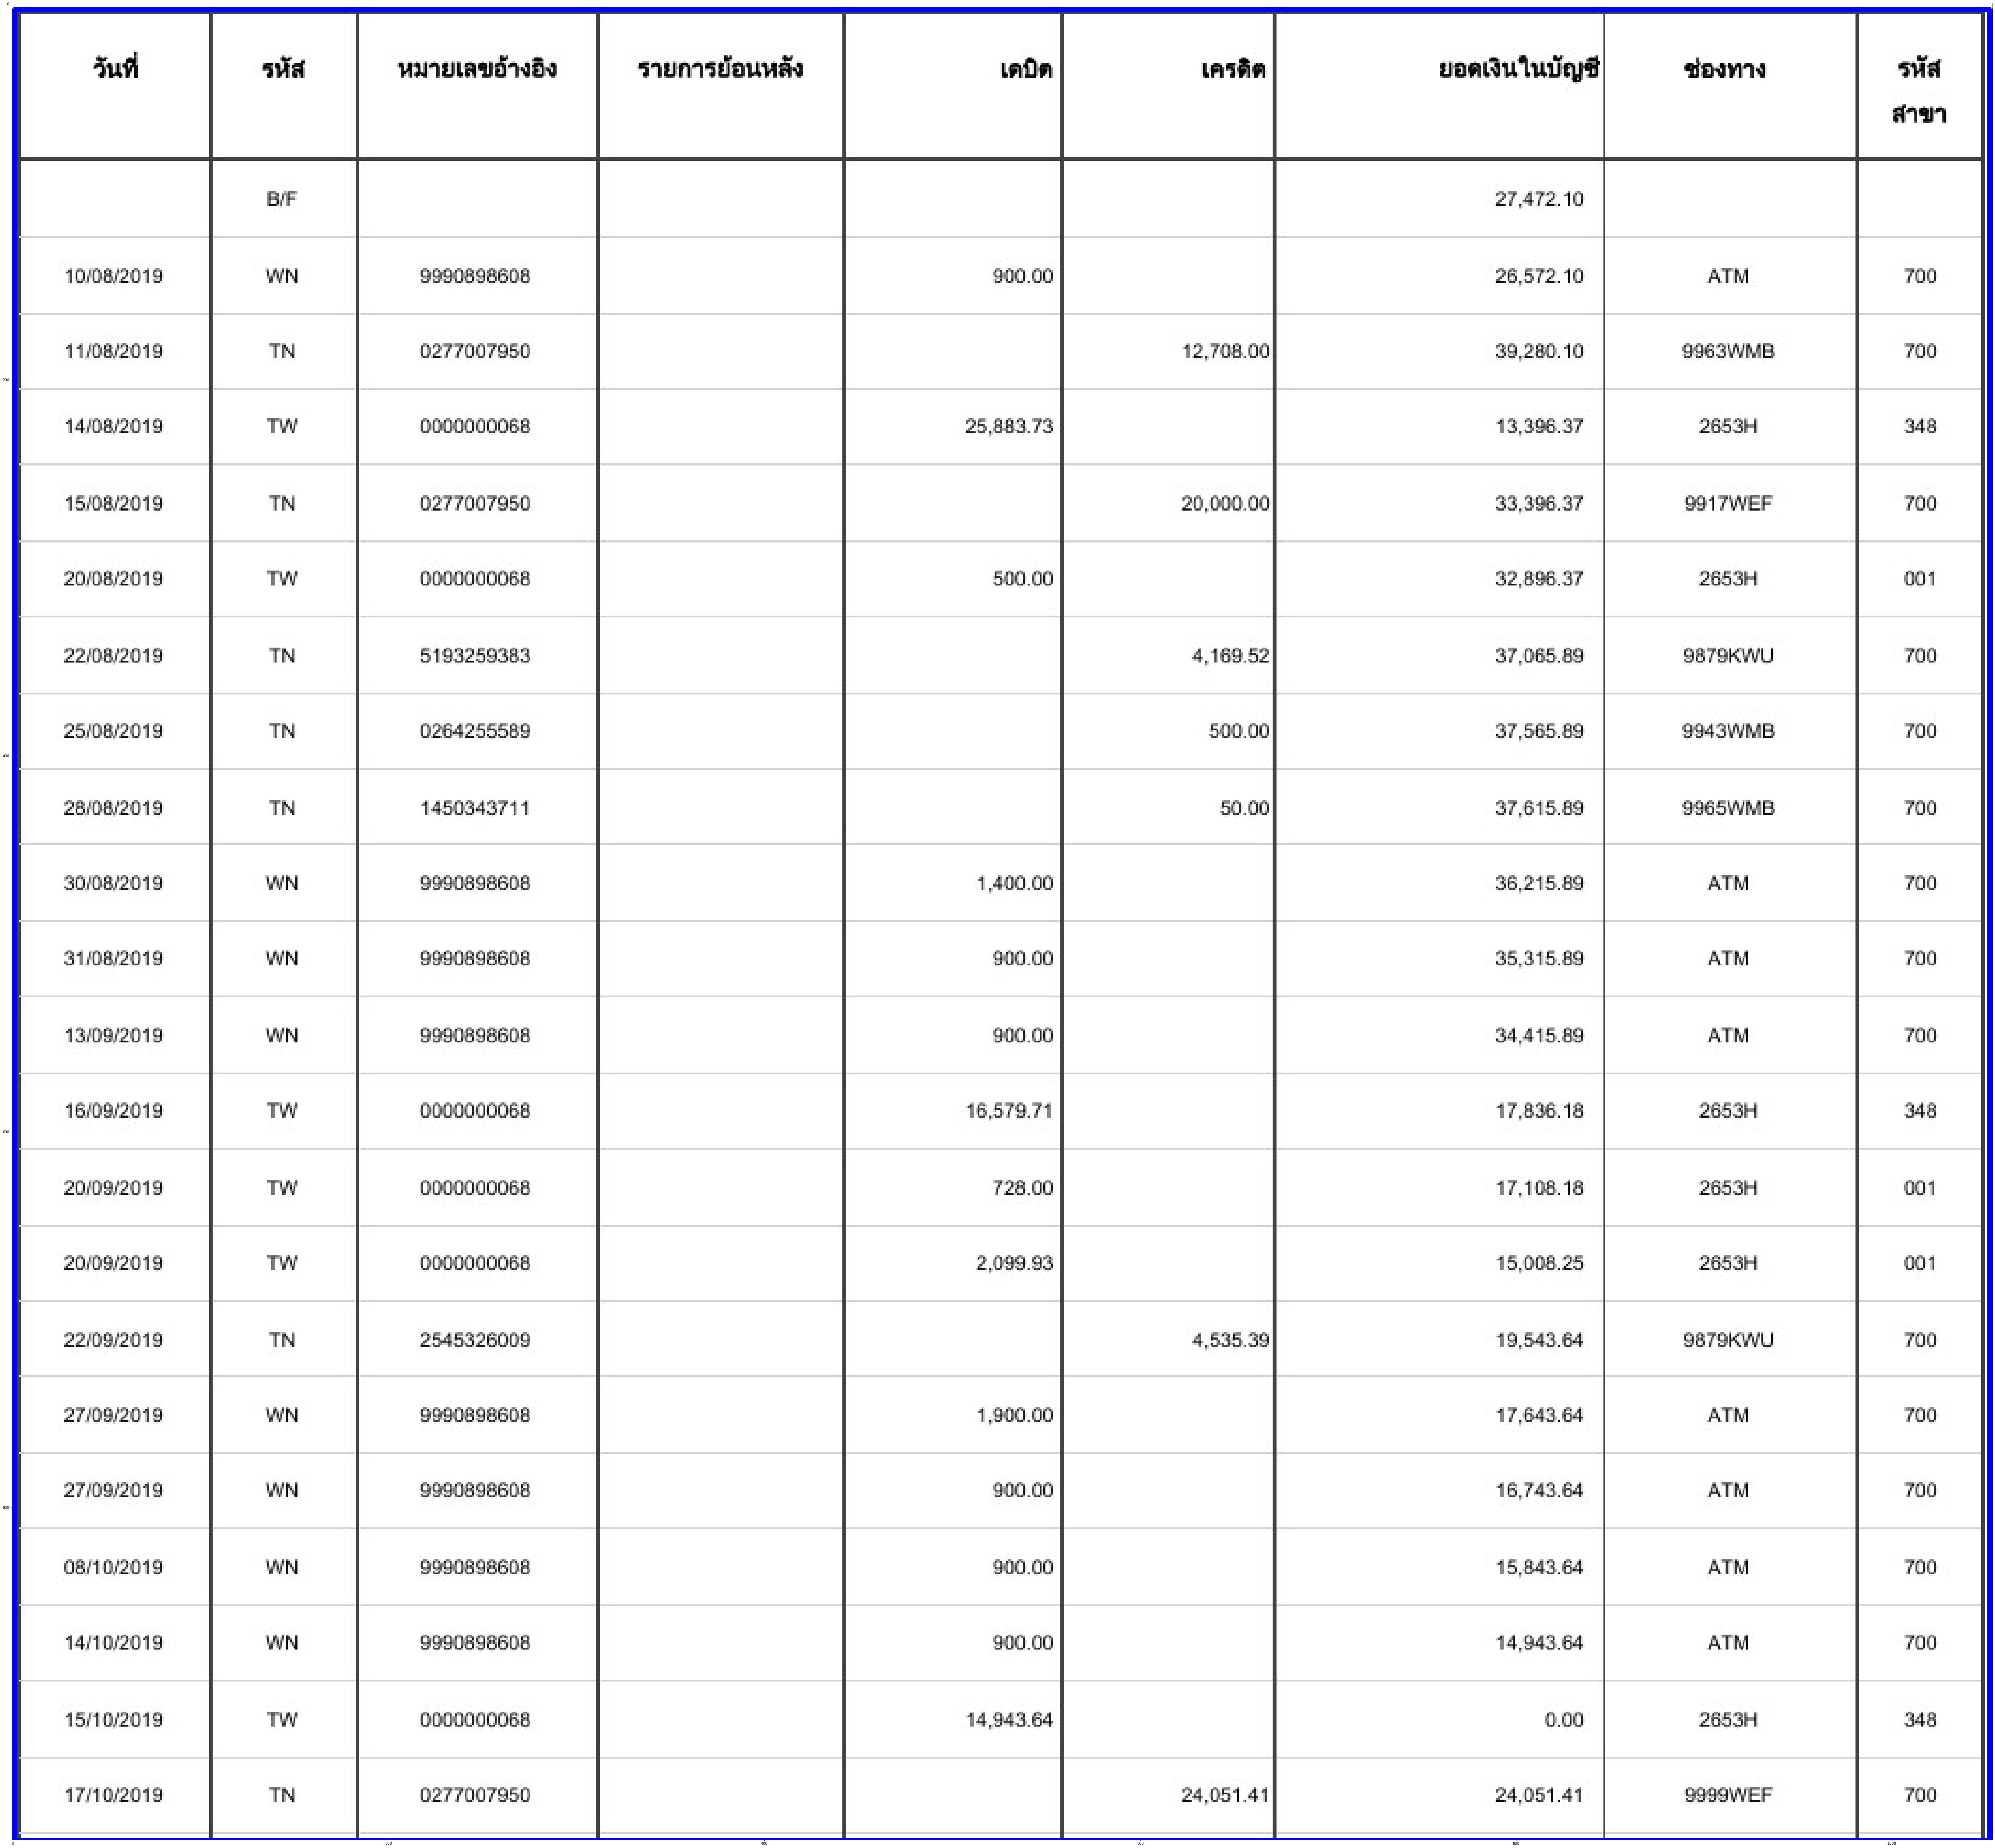

In [8]:
# find Table Rectangle

rect_area = []
for rect_pos in rect_pos_list:
    x, y, w, h = rect_pos
    area = w*h
    rect_area.append(area)
max_area_idx = np.argmax(rect_area)
x, y, w, h = rect_pos_list[max_area_idx]
print(x, y, w, h)

image_draw = image.copy()
cv2.rectangle(image_draw, (x, y), (x+w, y+h), (0, 0, 255), 2)
plt.imshow(image_draw)

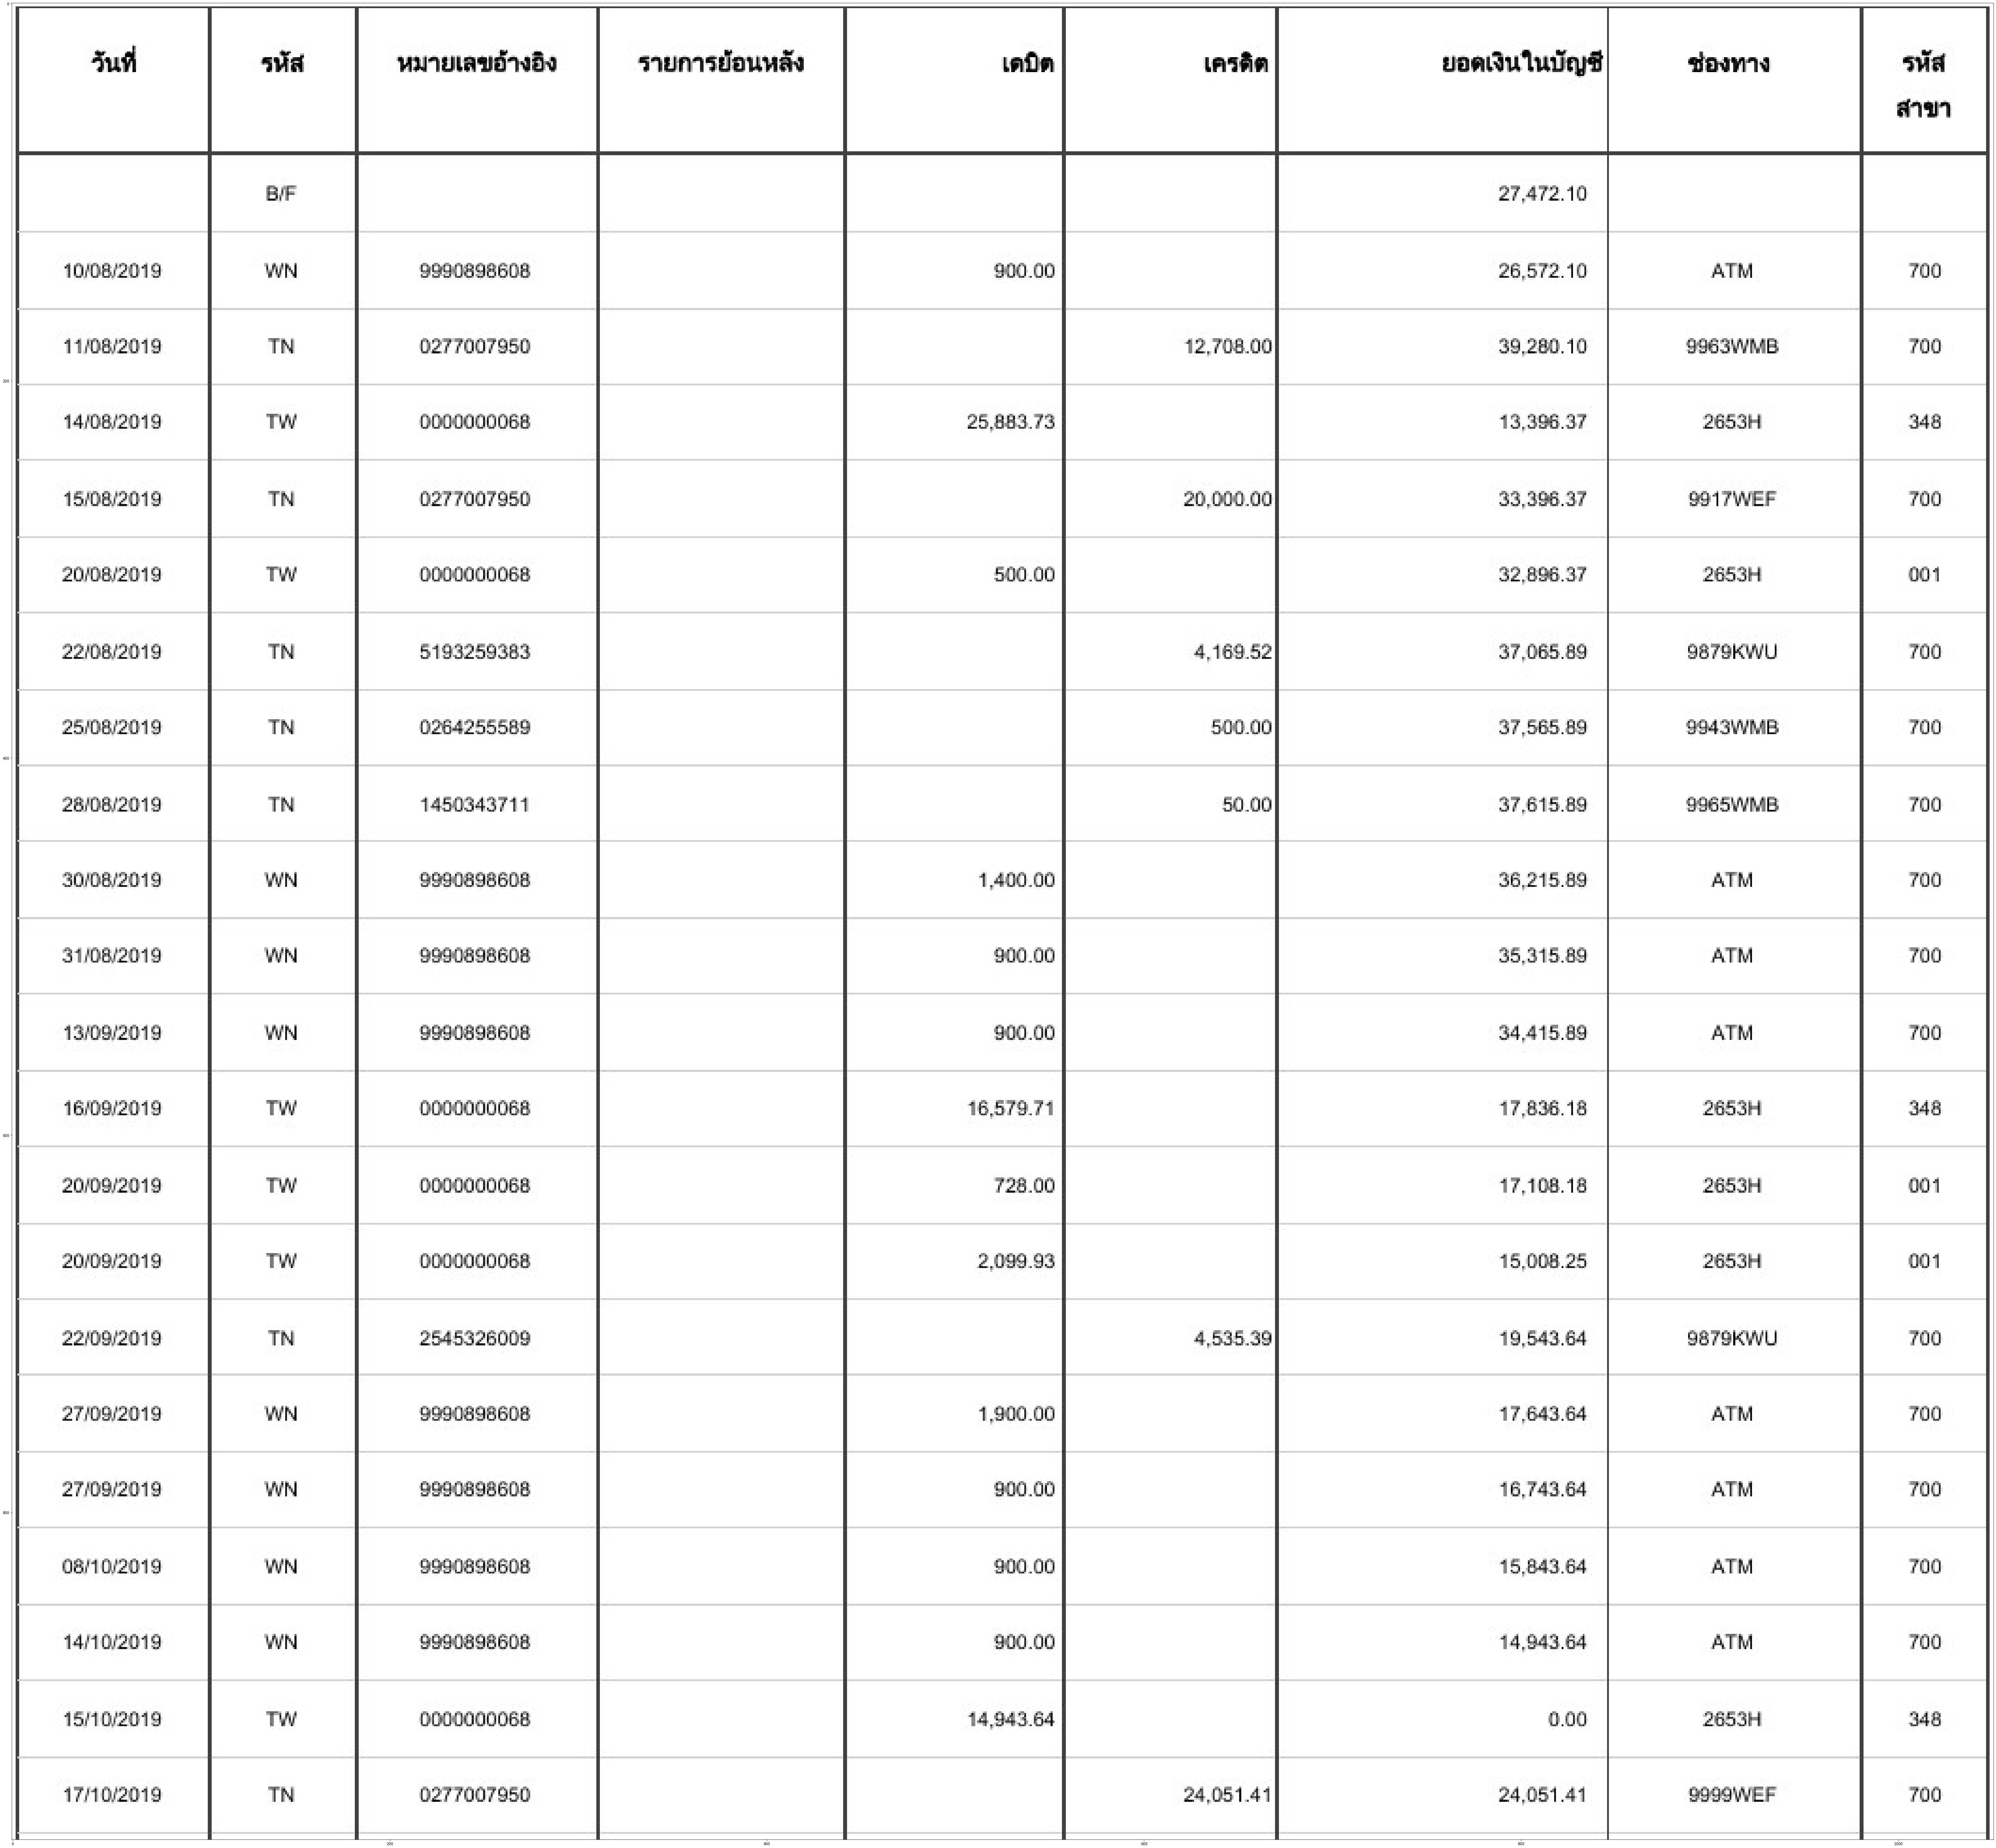

In [9]:
# crop Table
img_crop_table = image[y:y+h, x:x+w]
plt.imshow(img_crop_table)

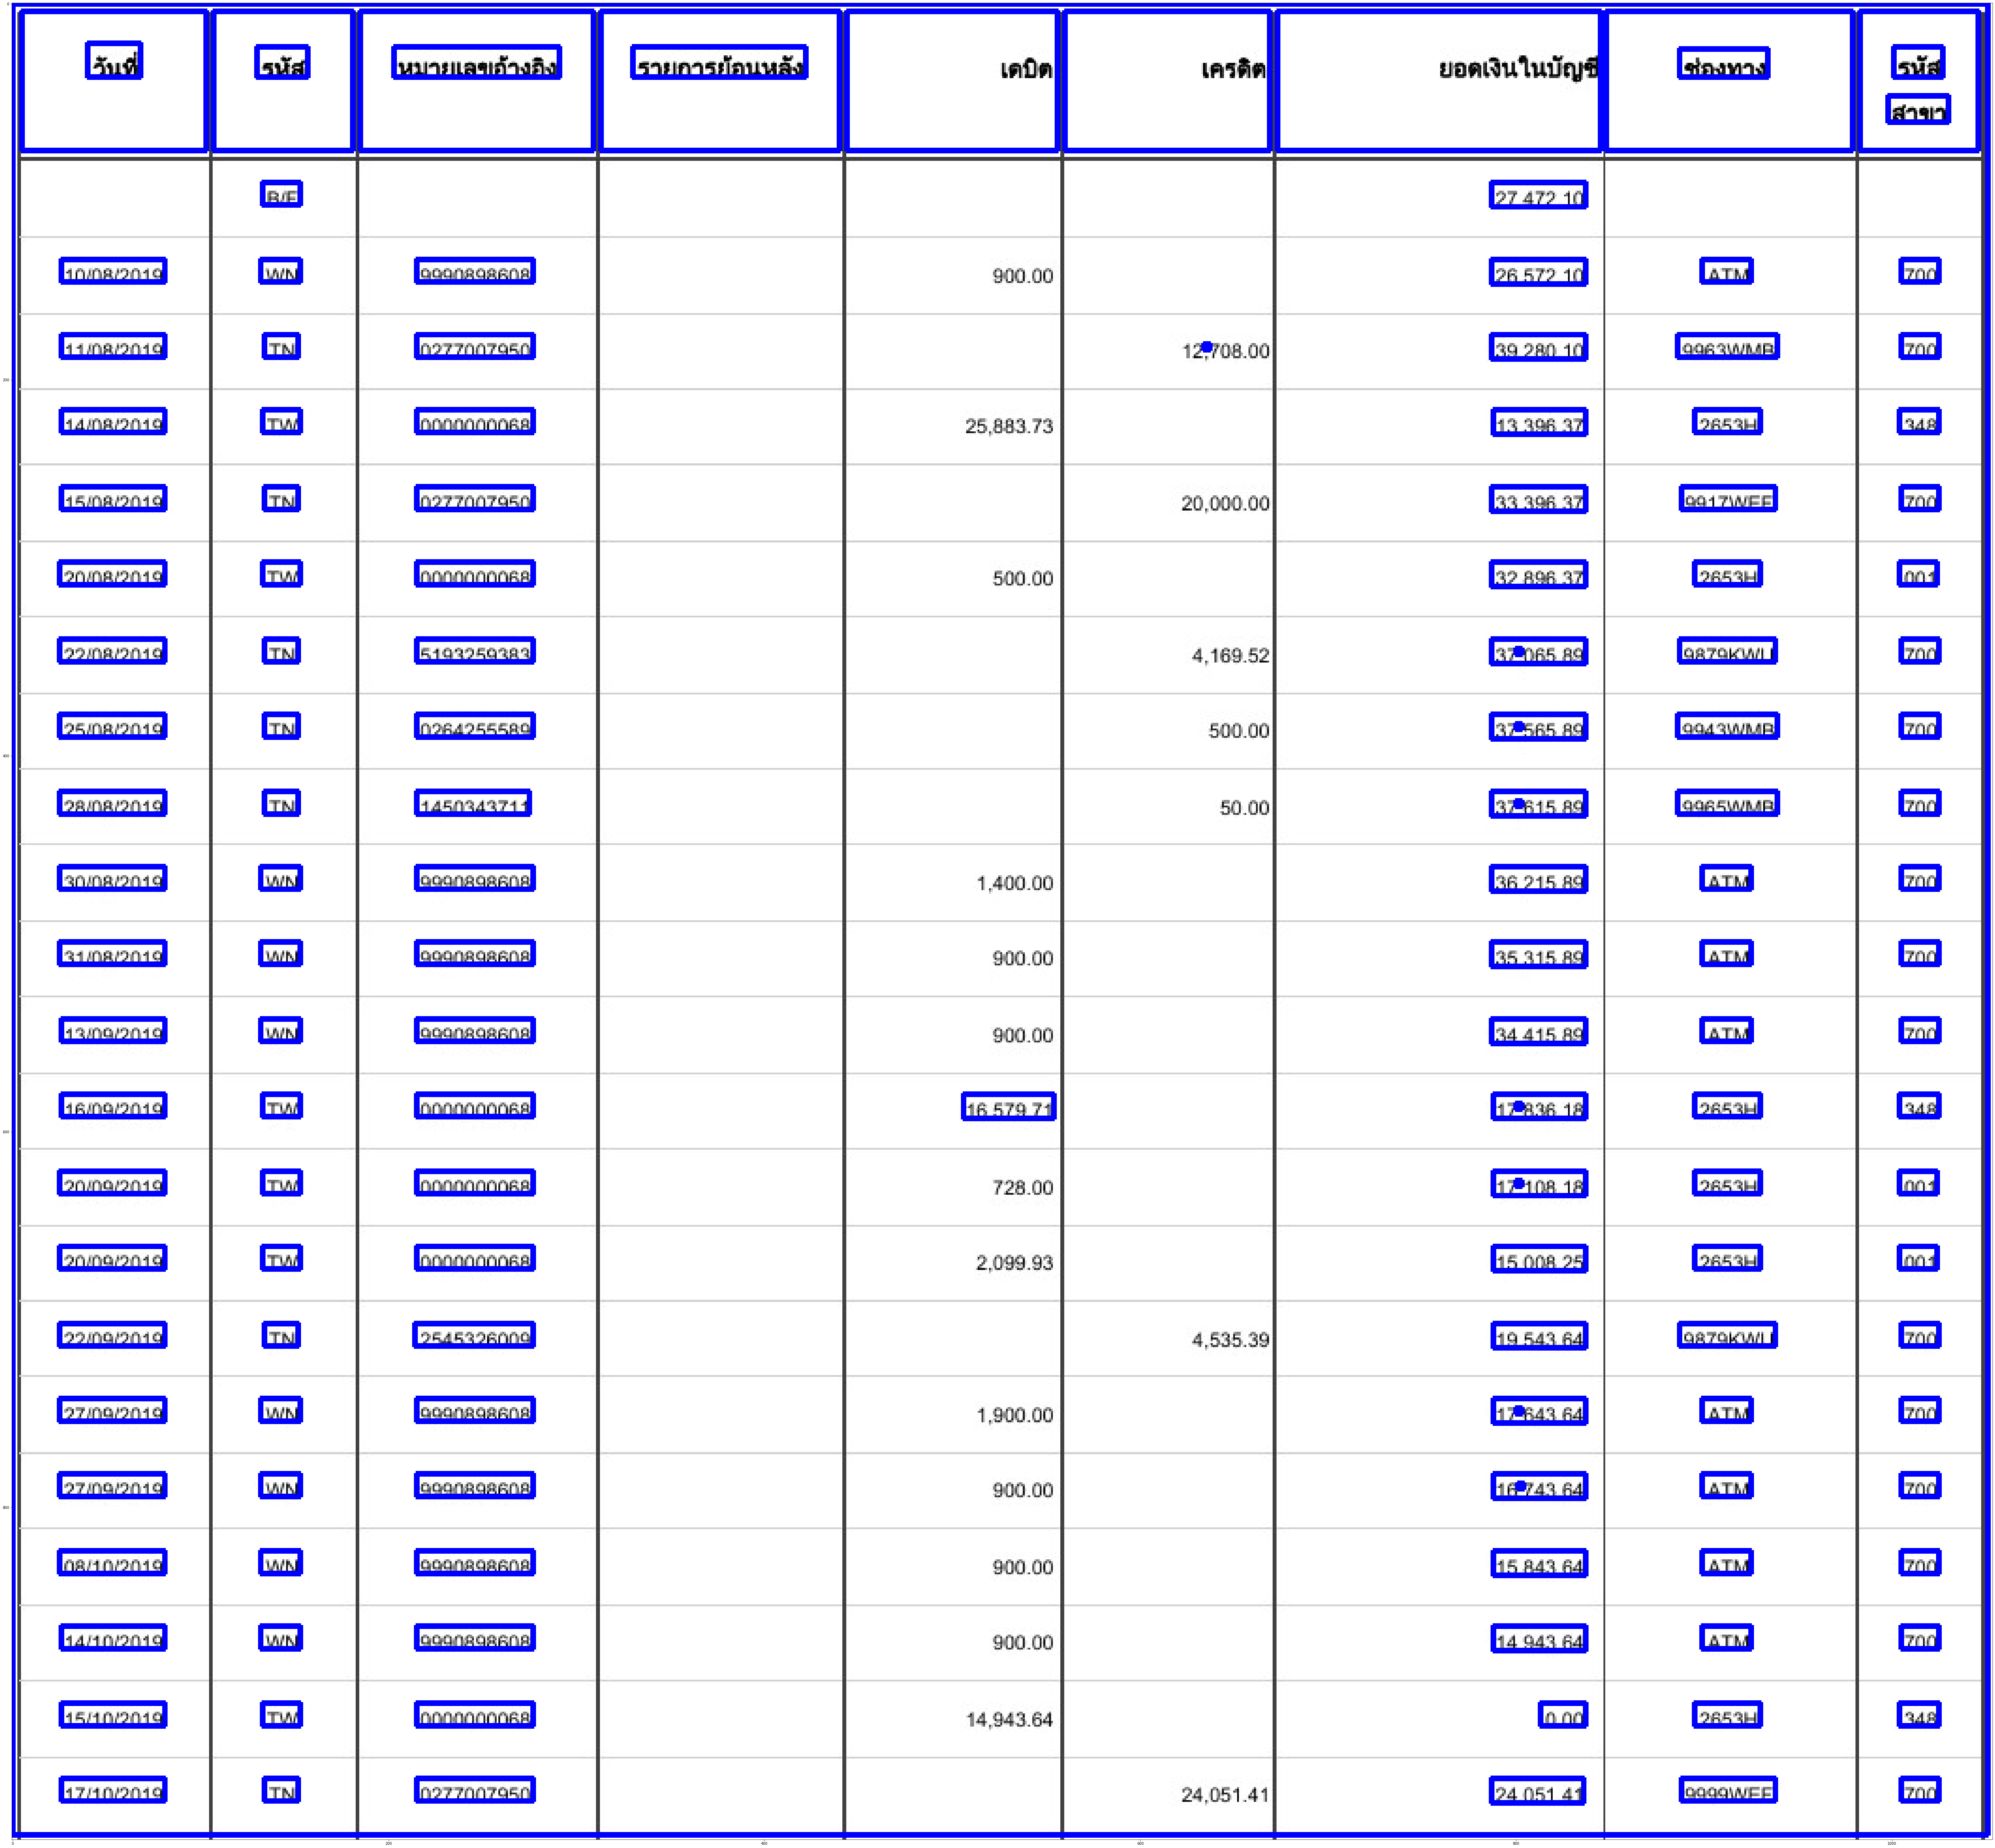

In [10]:
# find All Rectangle after crop table
img_gray = cv2.cvtColor(img_crop_table, cv2.COLOR_BGR2GRAY)
ret, thresh_value = cv2.threshold(img_gray, 180, 255, cv2.THRESH_BINARY_INV)

kernel = np.ones((5,5), np.uint8)
dilated_value = cv2.dilate(thresh_value, kernel, iterations=1)
contours, hierarchy = cv2.findContours(dilated_value, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

rect_pos_list = []
image_draw = image.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    rect_pos_list.append([x, y, w, h])
    cv2.rectangle(image_draw, (x, y), (x+w, y+h), (0, 0, 255), 2)

plt.imshow(image_draw)

[[5, 4, 98, 74], [107, 4, 74, 74], [185, 4, 124, 74], [313, 4, 127, 74], [444, 4, 112, 74], [560, 4, 109, 74], [673, 4, 172, 74], [848, 4, 131, 74], [983, 4, 63, 74]]


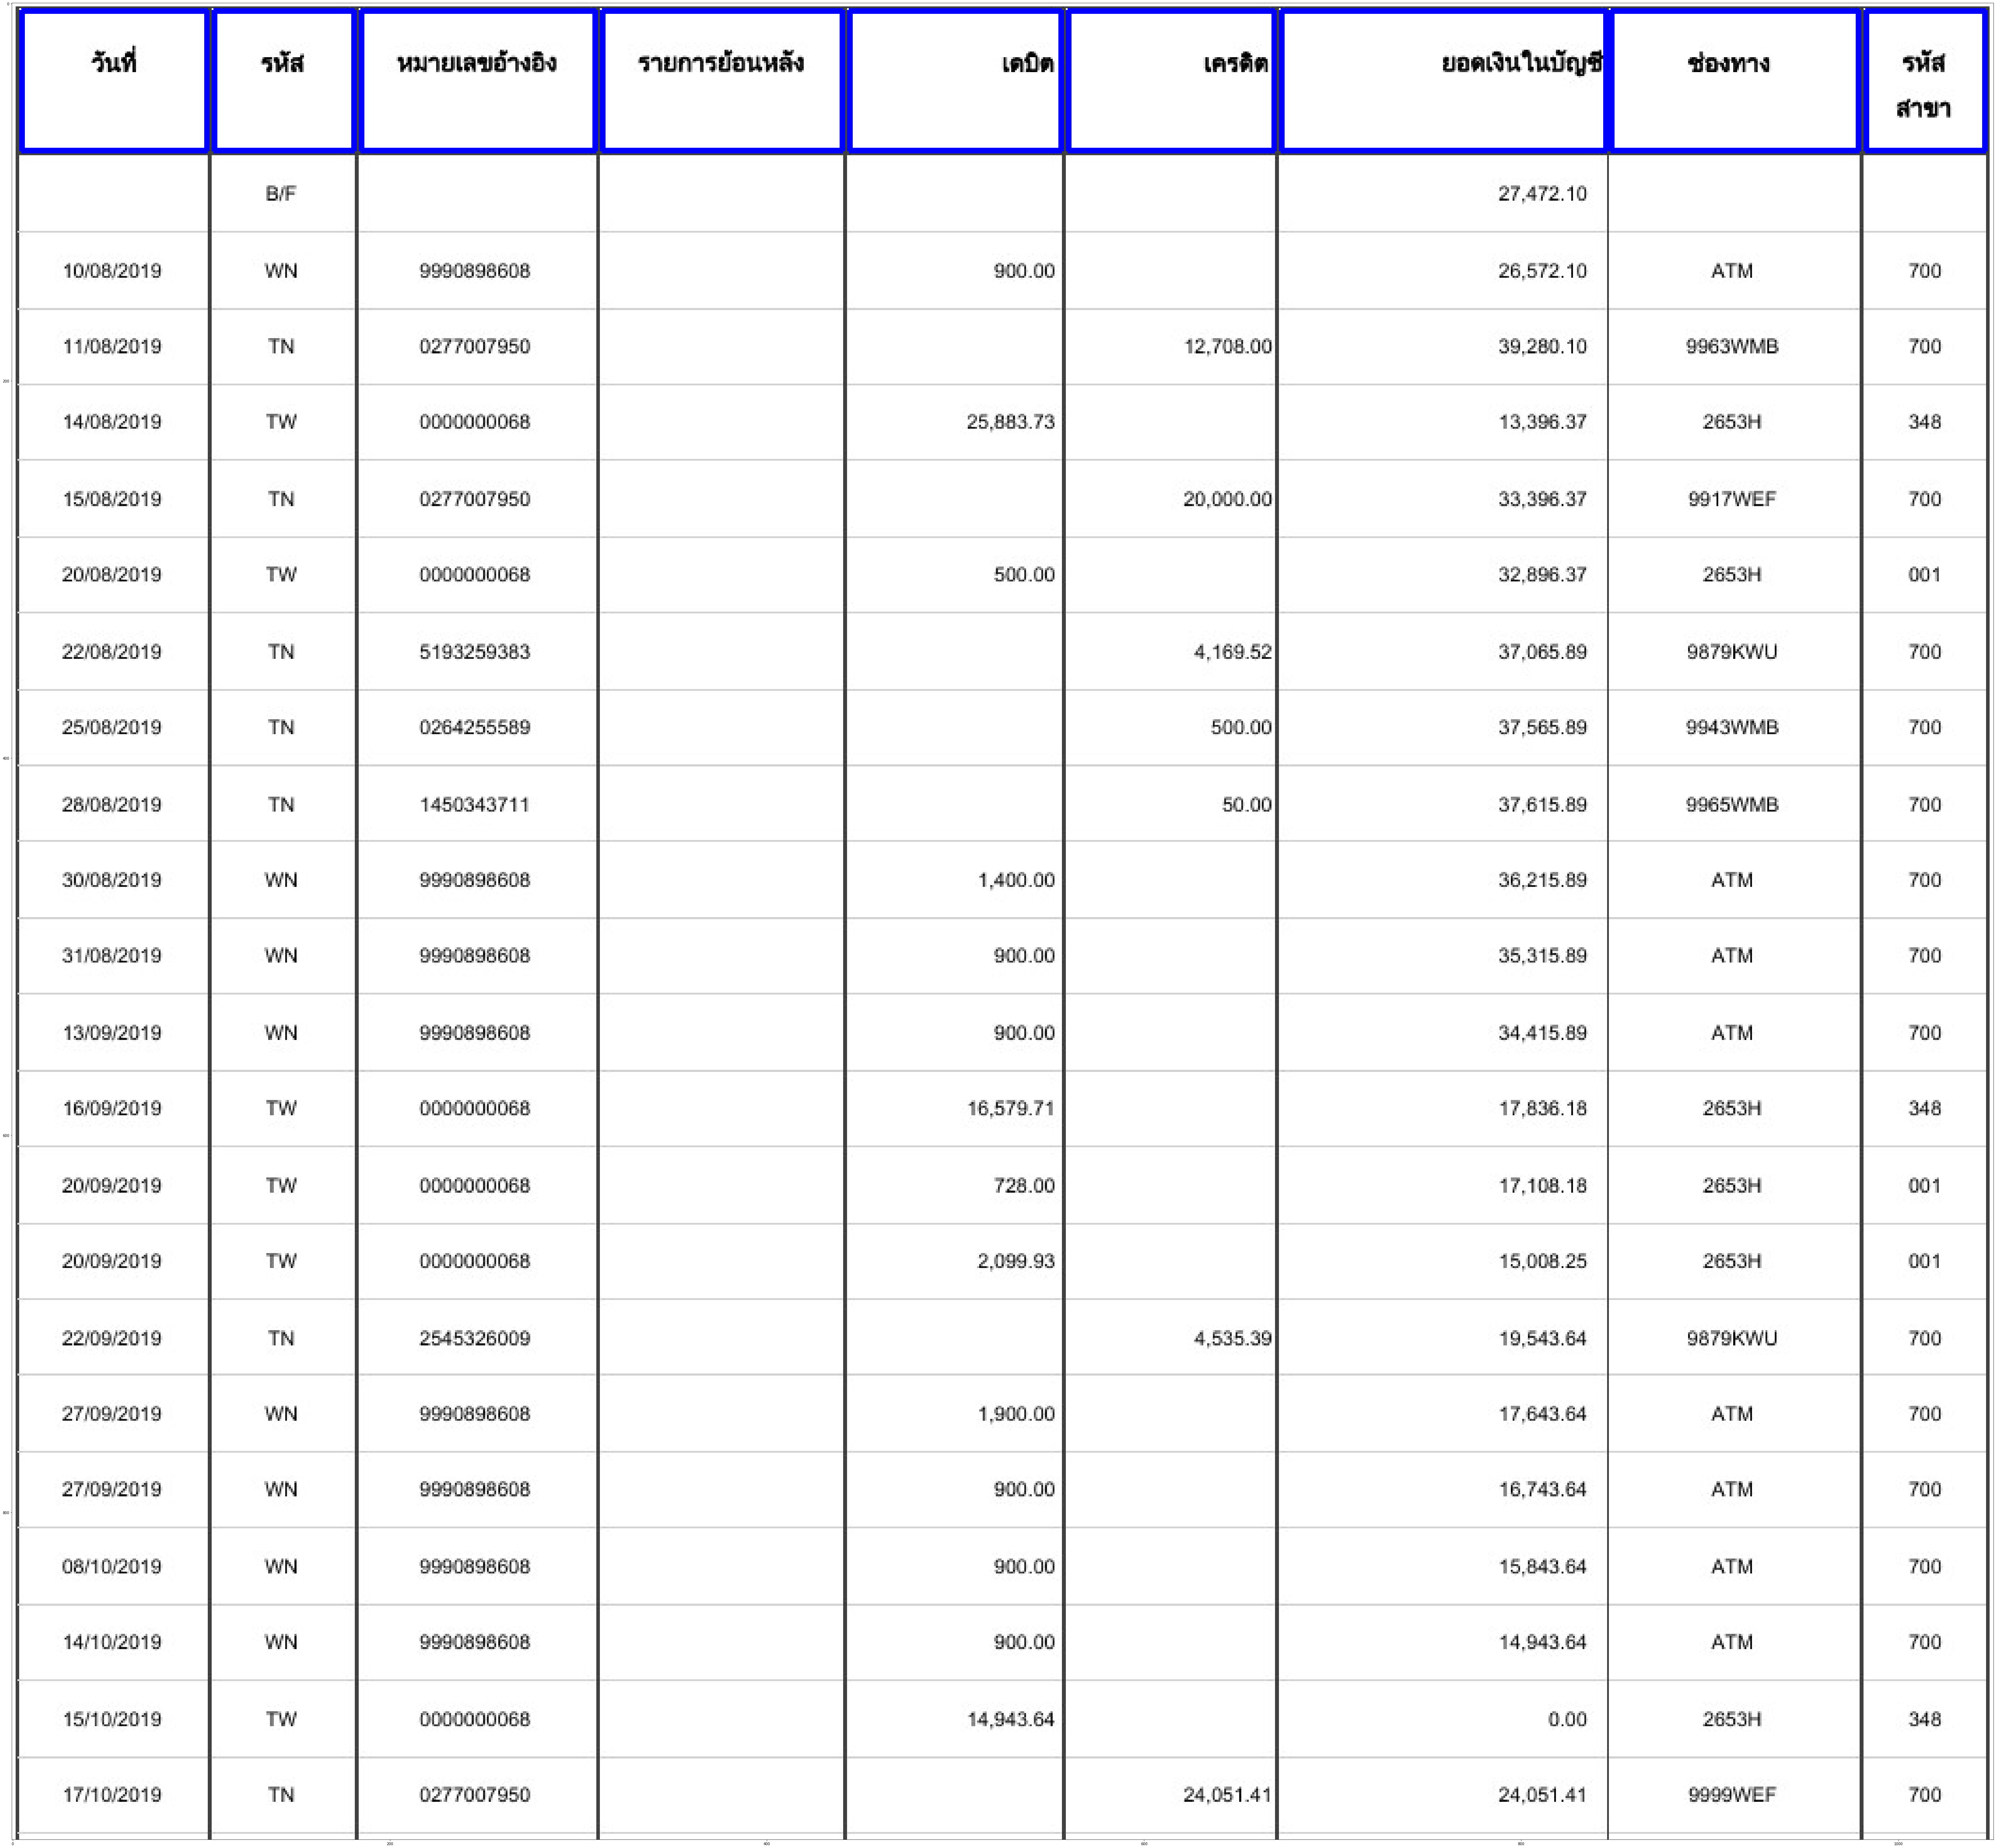

In [11]:
# find Header Rectangle(self, rect_pos_list):
header_pos = []
image_draw = img_crop_table.copy()
for rect_pos in rect_pos_list:
    x, y, w, h = rect_pos
    if w > 50 and w < 200 and h > 50 and h < 200:
        header_pos.append([x, y, w, h])
        cv2.rectangle(image_draw, (x, y), (x+w, y+h), (0, 0, 255), 2)
        
# sort Header LR
x_header_pos = [pos[0] for pos in header_pos]
idx_list = np.argsort(x_header_pos)
header_pos_sort_list = [header_pos[idx] for idx in idx_list]

print(header_pos_sort_list)
plt.imshow(image_draw)

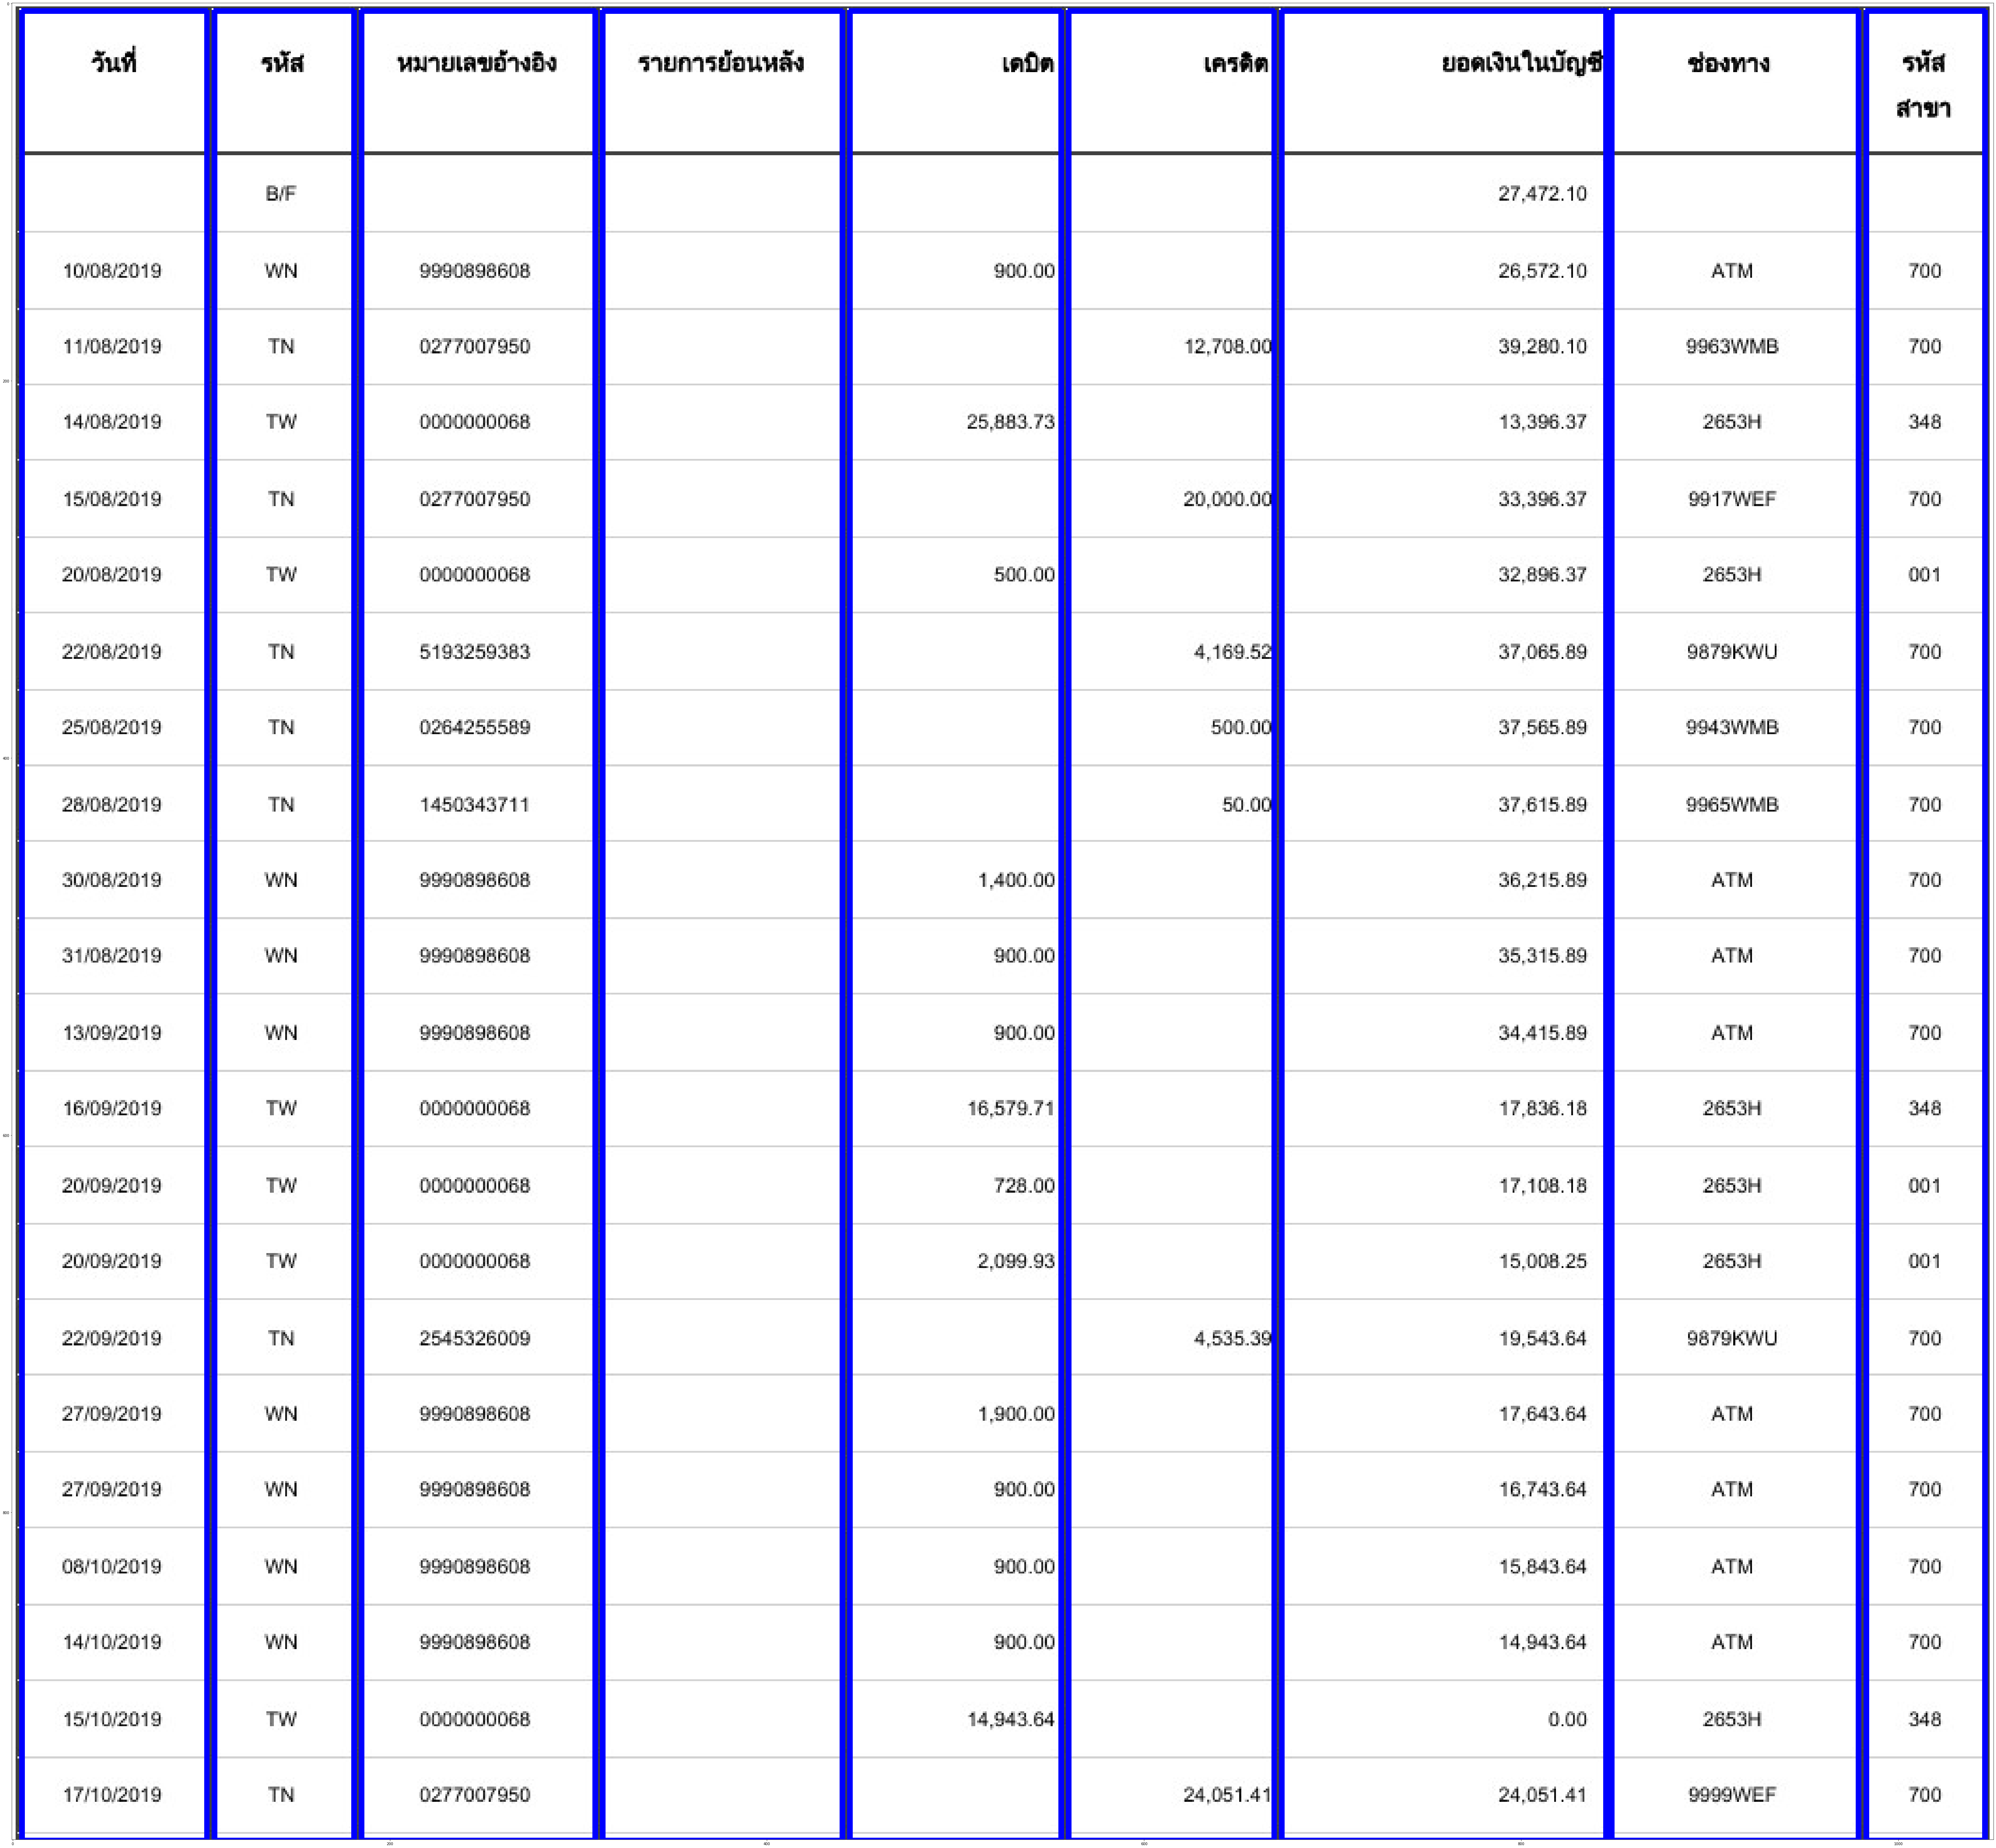

In [12]:
# crop Row and save

img_crop_row_list = []
image_draw = img_crop_table.copy()
img_h, img_w, _ = image_draw.shape
for i, header_pos_sort in enumerate(header_pos_sort_list):
    x, y, w, h = header_pos_sort
    path_img = "row_crop/" + str(i) + ".jpg"
    img_crop_row = image[y:, x:x+w]
    cv2.imwrite(path_img, img_crop_row)
    cv2.rectangle(image_draw, (x, y), (x+w, img_h), (0, 0, 255), 2)

plt.imshow(image_draw)

In [13]:
name = {'withdraval': "4.jpg", 'deposit': "5.jpg", 'balance': "6.jpg"}
filename = name['withdraval'] #change image here
path_img = "row_crop/" + filename

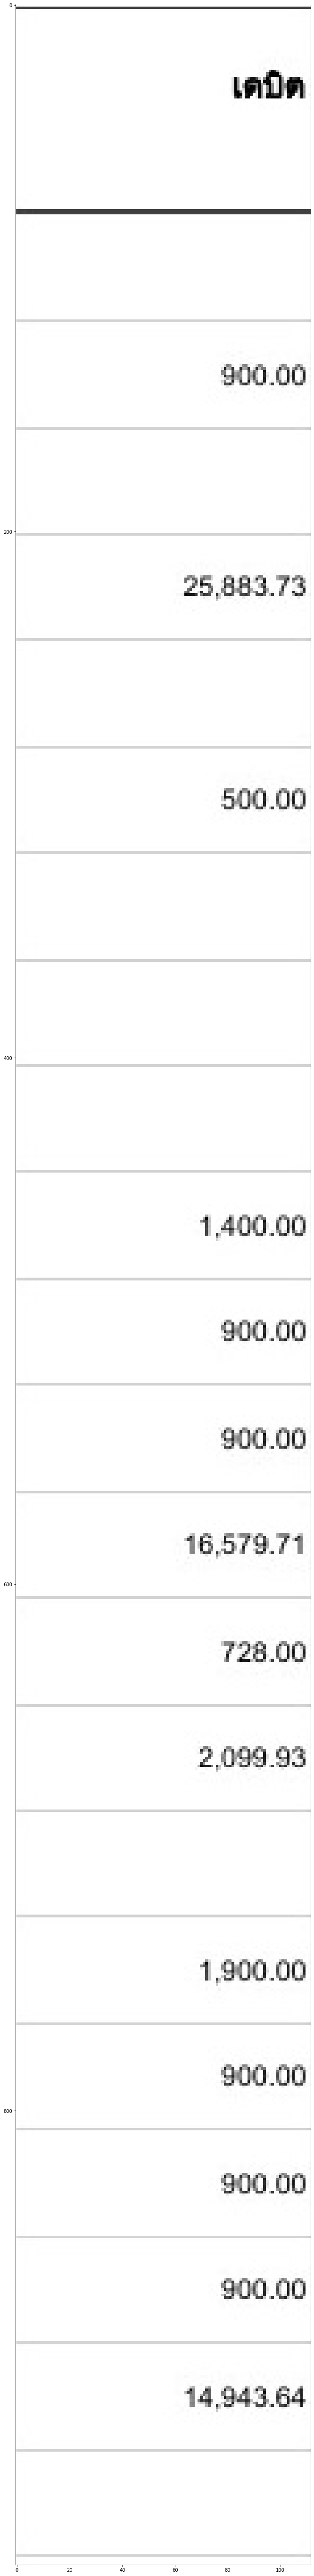

In [14]:
img_ex = cv2.imread(path_img)
plt.imshow(img_ex)

In [15]:
# ocr

url = "https://api.aiforthai.in.th/ocr"
files = {'uploadfile': open(path_img, 'rb')}
headers = {
    'Apikey': apiKey,
}

response = requests.post(url, files=files, headers=headers)
text = response.json()['Spellcorrection']
print(text)

กดบิด 

900.00 

25,083.73 

.500.00 

1.400.00 

900.00 

900.00 

16.579.71 

728.00 

2,099.93 

41,900.00 

900,00 

200,00 

200,00 

14,943.64 




In [16]:
# repair Text
text_list = text.split("\n")
print("text split : ", text_list)

text split :  ['กดบิด ', '', '900.00 ', '', '25,083.73 ', '', '.500.00 ', '', '1.400.00 ', '', '900.00 ', '', '900.00 ', '', '16.579.71 ', '', '728.00 ', '', '2,099.93 ', '', '41,900.00 ', '', '900,00 ', '', '200,00 ', '', '200,00 ', '', '14,943.64 ', '', '']


In [17]:
repaired_text_list = []
for text in text_list:
    if "." in text or "," in text:
        repaired_data = float(text.replace(
            ".", "").replace(",", ""))/100
        repaired_text_list.append(repaired_data)
print("result withdraval : ", repaired_text_list)

result withdraval :  [900.0, 25083.73, 500.0, 1400.0, 900.0, 900.0, 16579.71, 728.0, 2099.93, 41900.0, 900.0, 200.0, 200.0, 14943.64]


In [18]:
# deposit
filename = name['deposit']
path_img = "row_crop/" + filename
url = "https://api.aiforthai.in.th/ocr"
files = {'uploadfile': open(path_img, 'rb')}
headers = {
    'Apikey': apiKey,
}

response = requests.post(url, files=files, headers=headers)
text = response.json()['Spellcorrection']
text_list = text.split("\n")
repaired_text_list = []
for text in text_list:
    if "." in text or "," in text:
        repaired_data = float(text.replace(
            ".", "").replace(",", ""))/100
        repaired_text_list.append(repaired_data)
print("result deposit : ", repaired_text_list)

result deposit :  [12708.0, 20000.0, 4169.52, 500.0, 50.0, 4535.39, 24051.41]


In [20]:
# balance
filename = name['balance']
path_img = "row_crop/" + filename
url = "https://api.aiforthai.in.th/ocr"
files = {'uploadfile': open(path_img, 'rb')}
headers = {
    'Apikey': apiKey,
}

response = requests.post(url, files=files, headers=headers)
text = response.json()['Spellcorrection']
text_list = text.split("\n")
repaired_text_list = []
for text in text_list:
    if "." in text or "," in text:
        repaired_data = float(text.replace(
            ".", "").replace(",", ""))/100
        repaired_text_list.append(repaired_data)
print("result balance : ", repaired_text_list)

result balance :  [27472.1, 26572.1, 39280.1, 13396.37, 33396.37, 32696.37, 97085.69, 97565.69, 37615.69, 96215.69, 95515.69, 34415.69, 17896.18, 17108.18, 15008.25, 19543.64, 17843.64, 16743.64, 1543.64, 14983.64, 0.0, 24051.41]
